In [7]:
from _utils import *
from _polychrom import *
import glob
import re

In [65]:
save_dir = '/mnt/home/tudomlumleart/ceph/01_ChromatinEnsembleRefinement/chromatin-ensemble-refinement/figures/20241029'

In [2]:
def load_polymer_hdf5(polymer_directory, num_monomers):
    URIs = polychrom.hdf5_format.list_URIs(polymer_directory)
    if num_monomers is None:
        [num_monomers, _] = polychrom.hdf5_format.load_URI(URIs[0])["pos"].shape
    num_polymers = len(URIs)
    polys = np.full((num_monomers, 3, num_polymers), np.nan)
    dmaps = np.full((num_monomers, num_monomers, num_polymers), np.nan)
    for iURI, URI in tqdm(enumerate(URIs)):
        data = polychrom.hdf5_format.load_URI(URI)
        xyz = data["pos"]
        polys[:, :, iURI] = xyz[:num_monomers, :]
        dmaps[:, :, iURI] = squareform(pdist(xyz[:num_monomers, :]))
    return polys, dmaps

In [15]:
common_sim_dir = '/mnt/home/tudomlumleart/ceph/01_ChromatinEnsembleRefinement/chromatin-ensemble-refinement/md_results/'

# Find all folders in the common_sim_dir
# that starts with 20241028 using glob
sim_dirs = glob.glob(common_sim_dir + '20241028_Sox9_EmpiricalCTCF*')

In [16]:
sim_dirs[0]

'/mnt/home/tudomlumleart/ceph/01_ChromatinEnsembleRefinement/chromatin-ensemble-refinement/md_results/20241028_Sox9_EmpiricalCTCF_Lifetime10_Sepaation5'

In [17]:
simulation_dataset = {}
for folder in tqdm(sim_dirs):
    # Extract the lifetime and separation parameters from file name
    filename = folder.split('/')[-1]
    lifetime_str = filename.split('_')[3]
    lifetime_int = int(re.search(r'\d+$', lifetime_str).group())
    separation_str = filename.split('_')[4]
    separation_int = int(re.search(r'\d+$', separation_str).group())
    print(f'Lifetime: {lifetime_int}, Separation: {separation_int}')
    
    # Check if the folder is empty
    if not os.listdir(folder):
        print(f'Folder {folder} is empty')
        continue
    
    # Load the polymer data
    polys, dmaps = load_polymer_hdf5(folder, 5200)
    
    # Store the data in the simulation_dataset dictionary
    simulation_dataset[(lifetime_int, separation_int)] = {'polys': polys, 
                                                          'dmaps': dmaps}
    
    

  0%|          | 0/25 [00:00<?, ?it/s]

Lifetime: 10, Separation: 5


0it [00:00, ?it/s]

Lifetime: 5, Separation: 20


0it [00:00, ?it/s]

Lifetime: 20, Separation: 40


0it [00:00, ?it/s]

Lifetime: 80, Separation: 40


0it [00:00, ?it/s]

Lifetime: 40, Separation: 2
Folder /mnt/home/tudomlumleart/ceph/01_ChromatinEnsembleRefinement/chromatin-ensemble-refinement/md_results/20241028_Sox9_EmpiricalCTCF_Lifetime40_Sepaation2 is empty
Lifetime: 10, Separation: 2
Folder /mnt/home/tudomlumleart/ceph/01_ChromatinEnsembleRefinement/chromatin-ensemble-refinement/md_results/20241028_Sox9_EmpiricalCTCF_Lifetime10_Sepaation2 is empty
Lifetime: 5, Separation: 40


0it [00:00, ?it/s]

Lifetime: 80, Separation: 5


0it [00:00, ?it/s]

Lifetime: 5, Separation: 5


0it [00:00, ?it/s]

Lifetime: 20, Separation: 10


0it [00:00, ?it/s]

Lifetime: 5, Separation: 10


0it [00:00, ?it/s]

Lifetime: 20, Separation: 2
Folder /mnt/home/tudomlumleart/ceph/01_ChromatinEnsembleRefinement/chromatin-ensemble-refinement/md_results/20241028_Sox9_EmpiricalCTCF_Lifetime20_Sepaation2 is empty
Lifetime: 20, Separation: 5


0it [00:00, ?it/s]

Lifetime: 40, Separation: 40


0it [00:00, ?it/s]

Lifetime: 80, Separation: 2
Folder /mnt/home/tudomlumleart/ceph/01_ChromatinEnsembleRefinement/chromatin-ensemble-refinement/md_results/20241028_Sox9_EmpiricalCTCF_Lifetime80_Sepaation2 is empty
Lifetime: 10, Separation: 10


0it [00:00, ?it/s]

Lifetime: 5, Separation: 2
Folder /mnt/home/tudomlumleart/ceph/01_ChromatinEnsembleRefinement/chromatin-ensemble-refinement/md_results/20241028_Sox9_EmpiricalCTCF_Lifetime5_Sepaation2 is empty
Lifetime: 10, Separation: 40


0it [00:00, ?it/s]

Lifetime: 40, Separation: 10


0it [00:00, ?it/s]

Lifetime: 20, Separation: 20


0it [00:00, ?it/s]

Lifetime: 40, Separation: 5


0it [00:00, ?it/s]

Lifetime: 40, Separation: 20


0it [00:00, ?it/s]

Lifetime: 80, Separation: 10


0it [00:00, ?it/s]

Lifetime: 80, Separation: 20


0it [00:00, ?it/s]

Lifetime: 10, Separation: 20


0it [00:00, ?it/s]

In [18]:
len(simulation_dataset)

20

In [21]:
simulation_dmaps = {}
for key, value in simulation_dataset.items():
    curr_dmaps = value['dmaps']
    num_reps = curr_dmaps.shape[2]
    num_iters = curr_dmaps.shape[0] // 80
    sample_dmaps = []
    for i in range(num_reps):
        for j in range(num_iters):
            start = j*80
            end = (j+1)*80
            dmap = curr_dmaps[start:end, start:end, i]
            sample_dmaps.append(dmap)
    simulation_dmaps[key] = sample_dmaps

In [22]:
simulation_median_dmaps = {}
for key, value in simulation_dmaps.items():
    median_dmap = np.median(value, axis=0)
    simulation_median_dmaps[key] = median_dmap

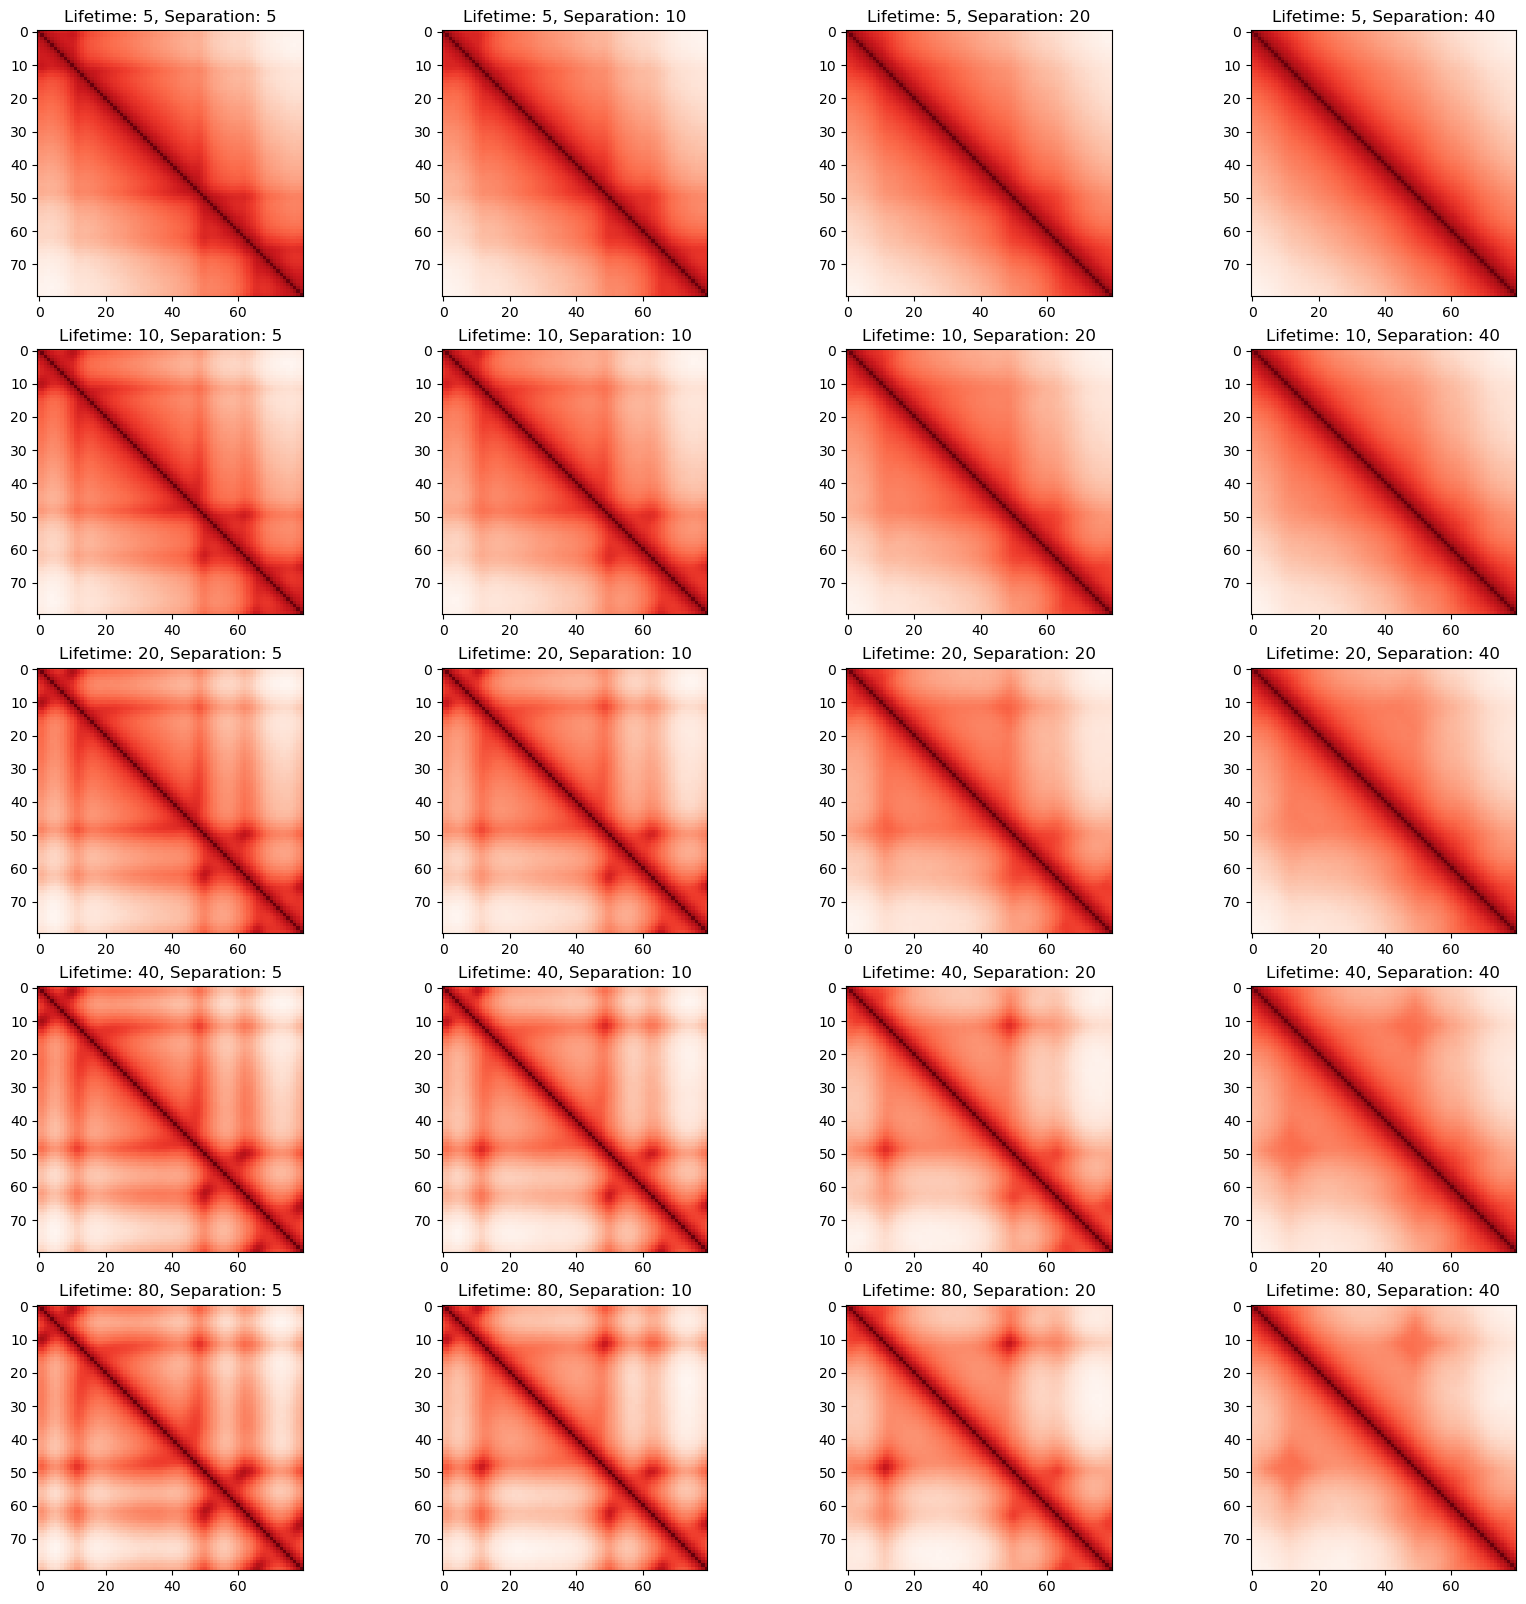

In [66]:
# Plot all 20 median distance maps
fig, axs = plt.subplots(5, 4, figsize=(20, 20))
axs = axs.flatten()
# Sort the keys by lifetime and separation
sorted_keys = sorted(simulation_median_dmaps.keys(), key=lambda x: (x[0], x[1]))
for i, key in enumerate(sorted_keys):
    ax = axs[i]
    dmap = simulation_median_dmaps[key]
    ax.imshow(dmap, cmap='Reds_r')
    ax.set_title(f'Lifetime: {key[0]}, Separation: {key[1]}')
    
plt.savefig(f'{save_dir}/median_distance_maps_simulations.png',
            bbox_inches='tight', dpi=300)

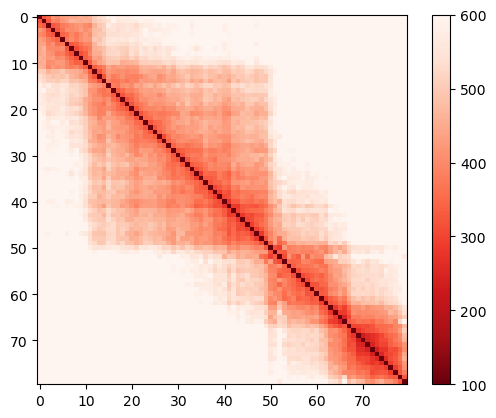

In [67]:
# Load the dataset
folder_path = '/mnt/home/tudomlumleart/ceph/05_Sox9Dataset/'
    
num_monomers = 80

# Load polys data and then perform linear interpolation
# List all .mat files in the folder and load them
cnc_polys = scipy.io.loadmat(folder_path + 'cncPols.mat')['cncPols'][:num_monomers, :, :]
esc_polys = scipy.io.loadmat(folder_path + 'escPols.mat')['escPols'][:num_monomers, :, :]

esc_maps = np.array([squareform(pdist(esc_polys[:80, :, i])) for i in range(esc_polys.shape[2])])
cnc_maps = np.array([squareform(pdist(cnc_polys[:80, :, i])) for i in range(cnc_polys.shape[2])])

plt.imshow(np.nanmedian(esc_maps, axis=0)[:80, :80], cmap='Reds_r',
           vmin=100, vmax=600)
plt.colorbar()
plt.savefig(f'{save_dir}/median_distance_map_esc.png',
            bbox_inches='tight', dpi=300)

In [26]:
esc_median_dmap = np.nanmedian(esc_maps, axis=0)[:80, :80]

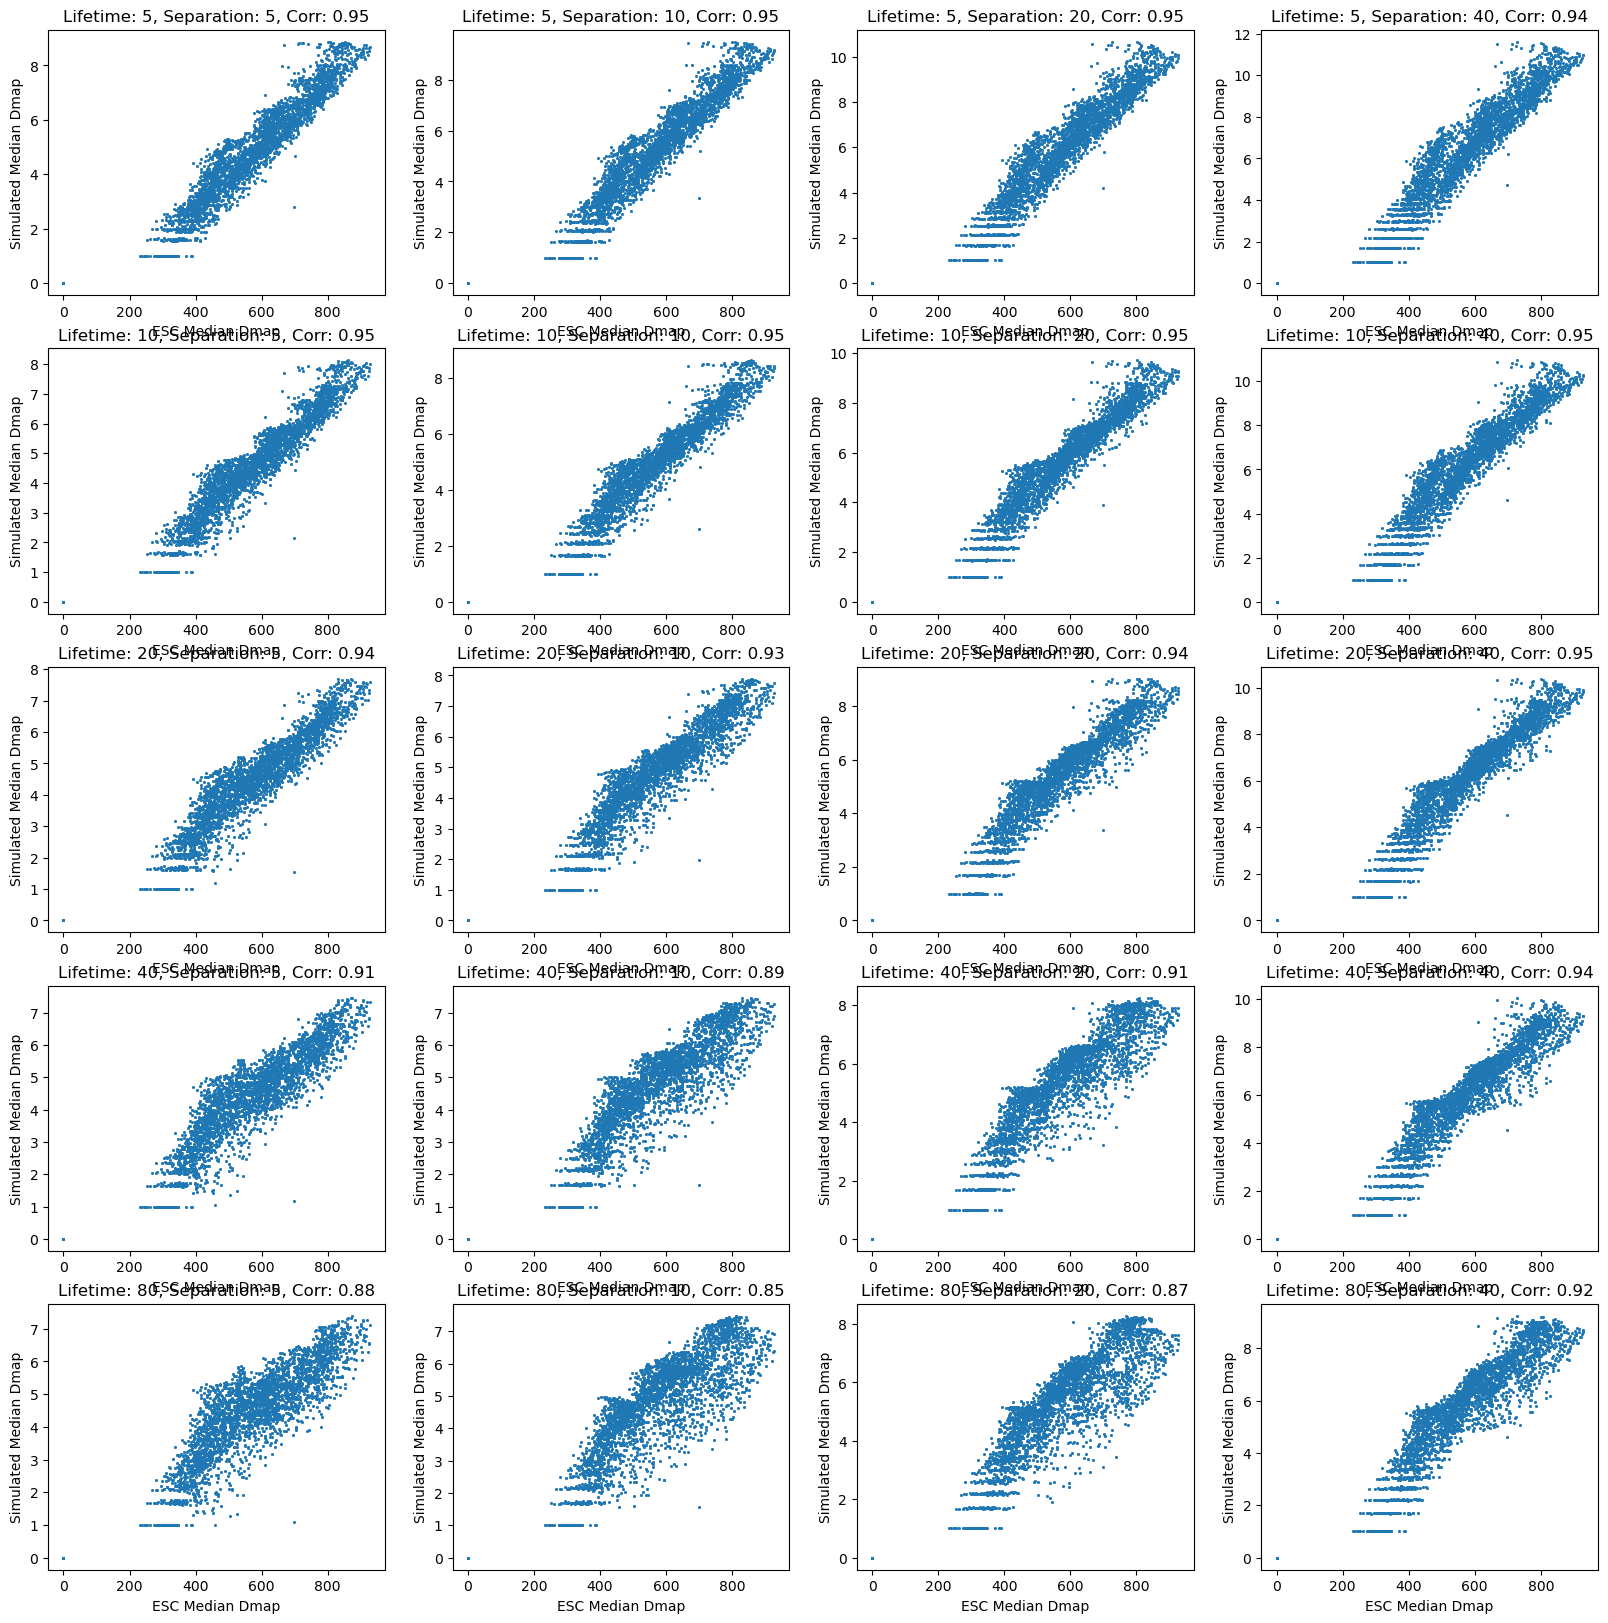

In [68]:
# Plot the scatterplots between simulated median dmaps and esc_median_dmap
# Sort the keys by lifetime and separation
sorted_keys = sorted(simulation_median_dmaps.keys(), key=lambda x: (x[0], x[1]))

fig, axs = plt.subplots(5, 4, figsize=(20, 20))
axs = axs.flatten()
for i, key in enumerate(sorted_keys):
    ax = axs[i]
    dmap = simulation_median_dmaps[key]
    ax.scatter(esc_median_dmap.flatten(), dmap.flatten(), s=1)
    # Calculate the correlation coefficient
    corr = np.corrcoef(esc_median_dmap.flatten(), dmap.flatten())[0, 1]
    ax.set_title(f'Lifetime: {key[0]}, Separation: {key[1]}, Corr: {corr:.2f}')
    ax.set_xlabel('ESC Median Dmap')
    ax.set_ylabel('Simulated Median Dmap')
plt.savefig(f'{save_dir}/correlation_sim_vs_esc.png',
            bbox_inches='tight', dpi=300)

In [35]:
# Find the Pearson correlation between simulated median dmaps and esc_median_dmap
# Sort the keys by lifetime and separation
sorted_keys = sorted(simulation_median_dmaps.keys(), key=lambda x: (x[0], x[1]))
correlations = {}
for key in sorted_keys:
    dmap = simulation_median_dmaps[key]
    corr = np.corrcoef(esc_median_dmap.flatten(), dmap.flatten())[0, 1]
    correlations[key] = corr

In [36]:
# Plot the correlation values
correlation_values = list(correlations.values())

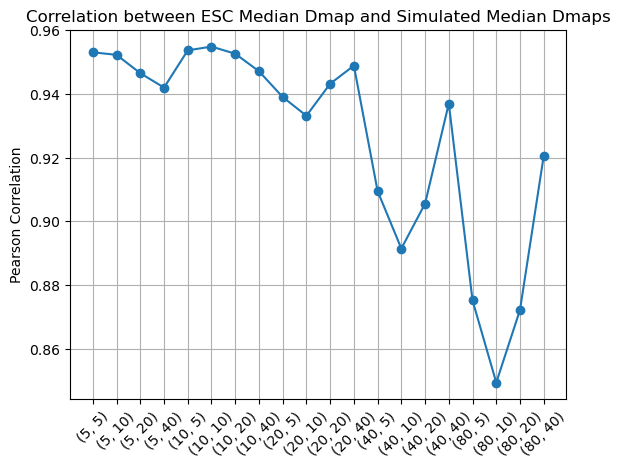

In [71]:
plt.plot(correlation_values, 'o-')
# Add the lifetime and separation values to the x-axis
plt.xticks(range(len(correlation_values)), sorted_keys, rotation=45)
# Add grid
plt.grid()
plt.ylabel('Pearson Correlation')
plt.title('Correlation between ESC Median Dmap and Simulated Median Dmaps')
plt.savefig(f'{save_dir}/correlation_values.png',
            bbox_inches='tight', dpi=300)

In [43]:
best_params = sorted_keys[np.argmax(correlation_values)]
print(best_params)

(10, 10)


In [40]:
esc_polys_interp = interpolate_polymers(esc_polys)
cnc_polys_interp = interpolate_polymers(cnc_polys)

def calculate_distance_map(polys):
    # Extract the dimensions of the input array
    num_probes, num_coords, num_cells = polys.shape
    
    # Initialize an array of the same shape to hold the interpolated values
    new_maps = np.zeros((num_cells, num_probes, num_probes))
    
    # Iterate over each cell
    for c in range(num_cells):
        # Extract the data for the current cell
        curr_cells = polys[:, :, c]
        
        # Skip cells with all missing values
        if np.all(np.isnan(curr_cells)):
            continue  # This leaves a matrix of zeros in the output array
        
        # Calculate the pairwise Euclidean distance between each pair of probes
        dmap = squareform(pdist(curr_cells))
        
        # Assign the distance map to the corresponding position in the output array
        new_maps[c, :, :] = dmap
    
    # Return the array with interpolated values
    return new_maps

esc_maps_interp = calculate_distance_map(esc_polys_interp)
cnc_maps_interp = calculate_distance_map(cnc_polys_interp)
esc_maps_interp_flat = np.array([x.flatten() for x in esc_maps_interp])
cnc_maps_interp_flat = np.array([x.flatten() for x in cnc_maps_interp])
all_maps_interp = np.concatenate((esc_maps_interp, cnc_maps_interp), axis=0)
all_maps_interp_flat = np.concatenate((esc_maps_interp_flat, cnc_maps_interp_flat), axis=0)


In [41]:
pca = PCA(n_components=2)  # Change here for the number of dimensions
pca.fit(all_maps_interp_flat)
esc_maps_pca = pca.transform(esc_maps_interp_flat)
cnc_maps_pca = pca.transform(cnc_maps_interp_flat)

all_maps_pca = np.concatenate((esc_maps_pca, cnc_maps_pca), axis=0)

In [56]:
dmaps_best_params = np.array(simulation_dmaps[best_params])
print(dmaps_best_params.shape)

(6500, 80, 80)


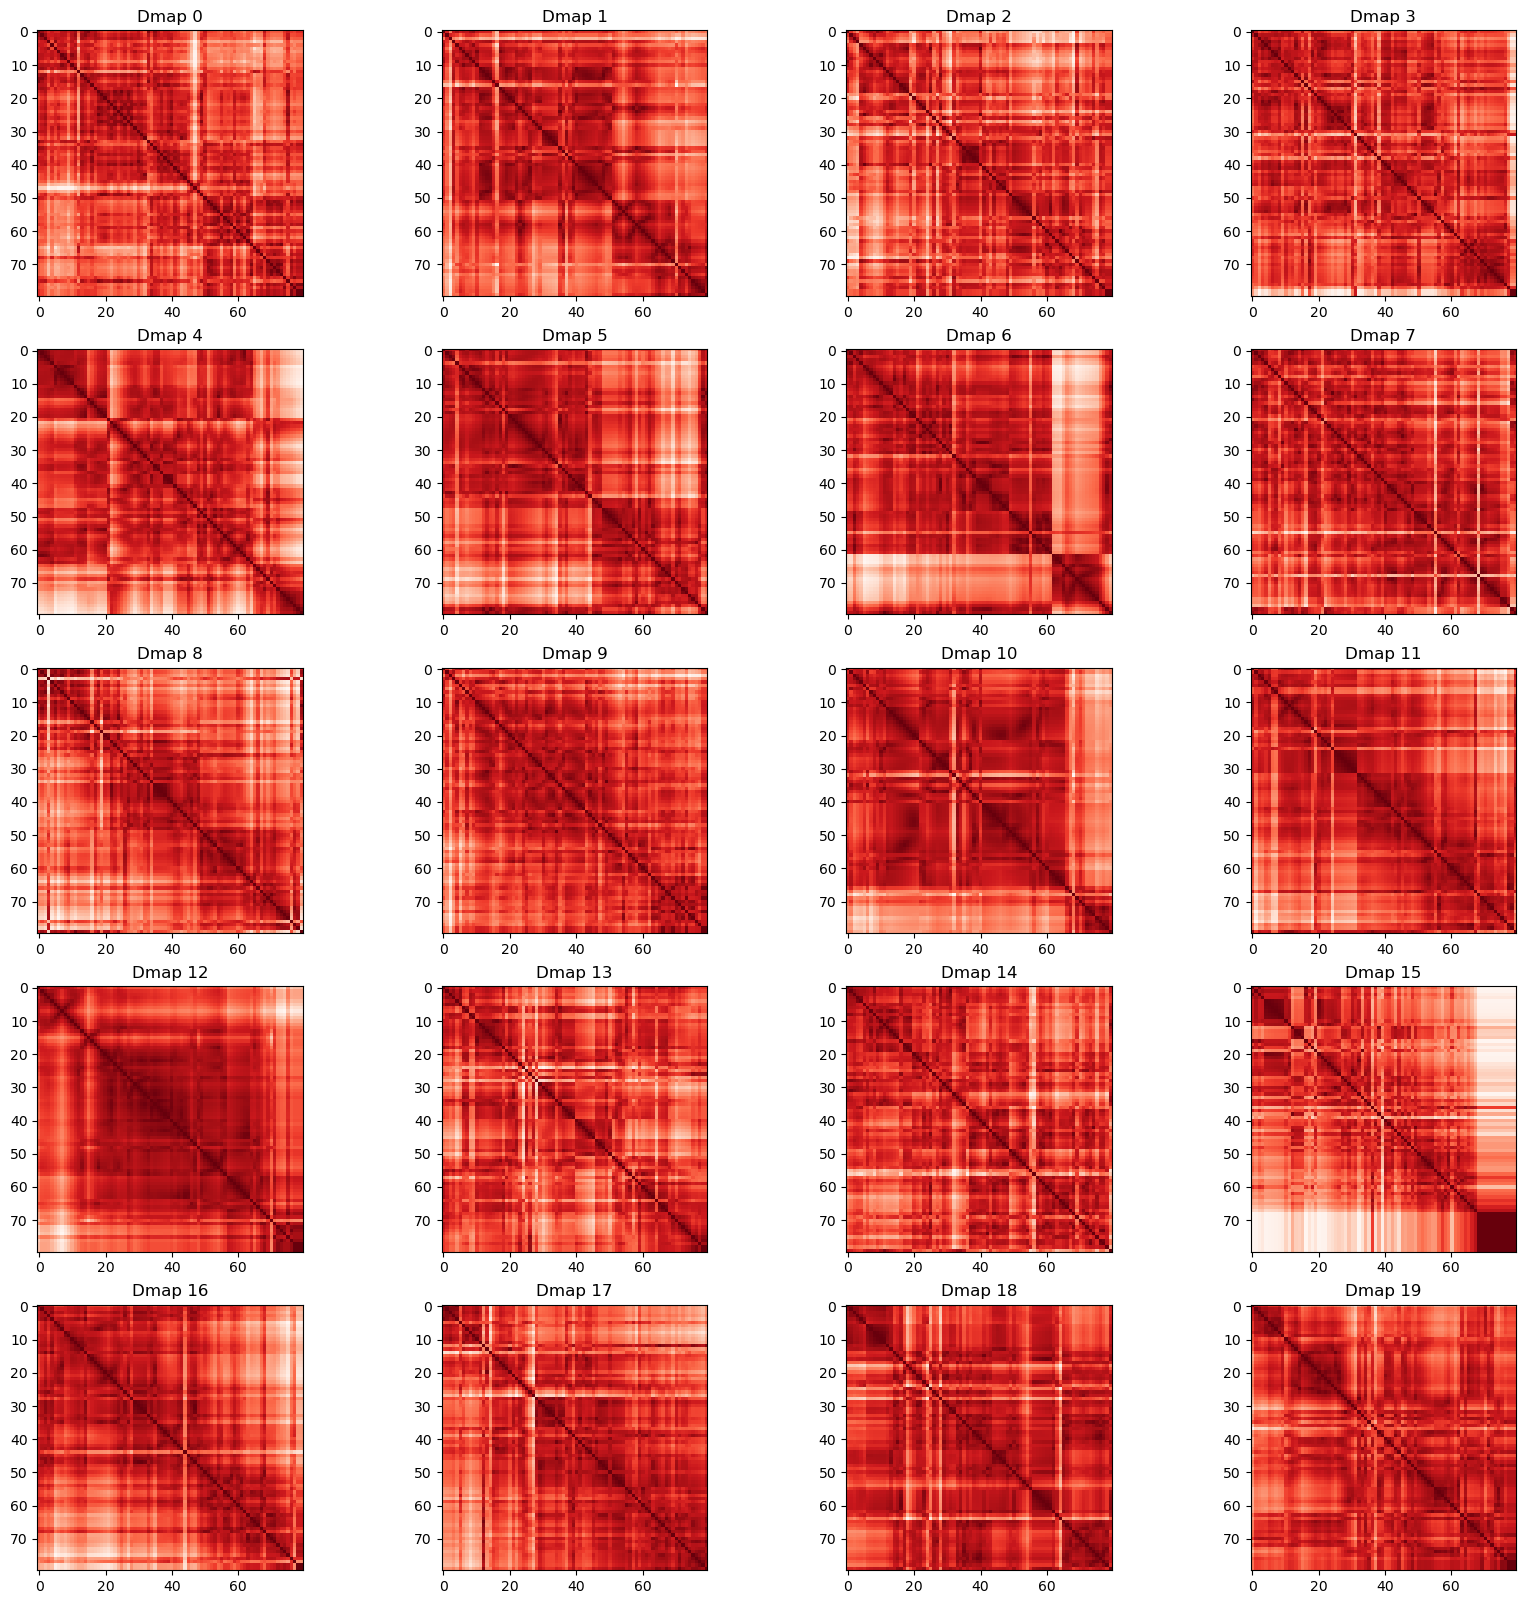

In [72]:
# plot the first 20 dmaps from esc dataset
fig, axs = plt.subplots(5, 4, figsize=(20, 20))
axs = axs.flatten()
for i in range(20):
    ax = axs[i]
    ax.imshow(esc_maps_interp[i], cmap='Reds_r')
    ax.set_title(f'Dmap {i}')
plt.savefig(f'{save_dir}/esc_dmaps.png',
            bbox_inches='tight', dpi=300)

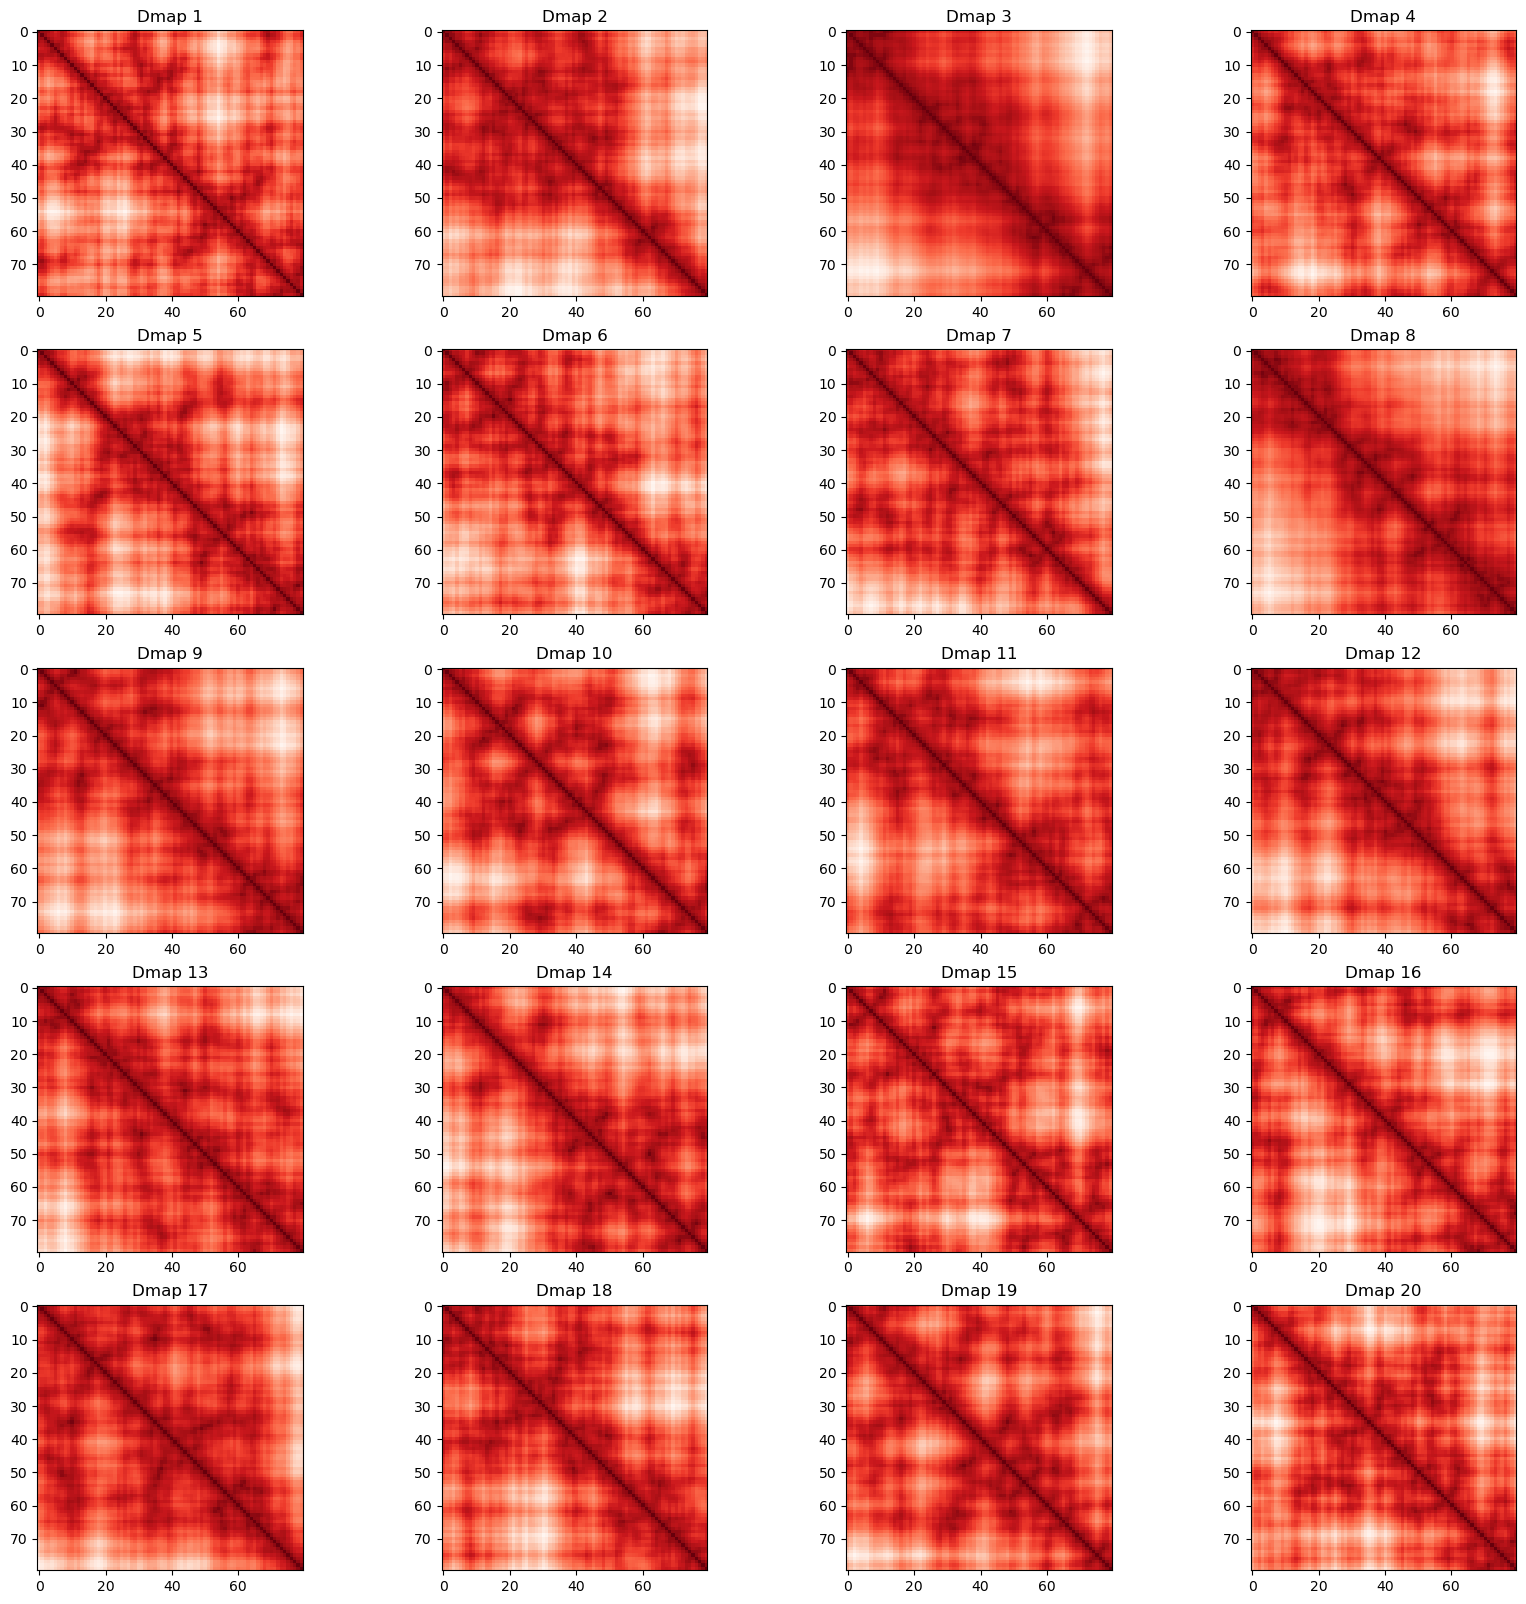

In [73]:
# plot the first 20 dmaps for the best parameters
fig, axs = plt.subplots(5, 4, figsize=(20, 20))
axs = axs.flatten()
for i, dmap in enumerate(dmaps_best_params[:20]):
    ax = axs[i]
    ax.imshow(dmap, cmap='Reds_r')
    ax.set_title(f'Dmap {i+1}')
plt.savefig(f'{save_dir}/sim_dmaps_best_params.png',
            bbox_inches='tight', dpi=300)

In [47]:
dmaps_best_params_flat = np.array([x.flatten() for x in dmaps_best_params])

In [48]:
dmaps_sim_pca = pca.transform(dmaps_best_params_flat)

In [49]:
esc_pca_df = pd.DataFrame(esc_maps_pca, columns=['PC1', 'PC2'])
esc_pca_df['Cell Type'] = 'ESC'
cnc_pca_df = pd.DataFrame(cnc_maps_pca, columns=['PC1', 'PC2'])
cnc_pca_df['Cell Type'] = 'CNC'
sim_pca_df = pd.DataFrame(dmaps_sim_pca, columns=['PC1', 'PC2'])
sim_pca_df['Cell Type'] = 'Simulated'
all_pca_df = pd.concat([esc_pca_df, cnc_pca_df, sim_pca_df])

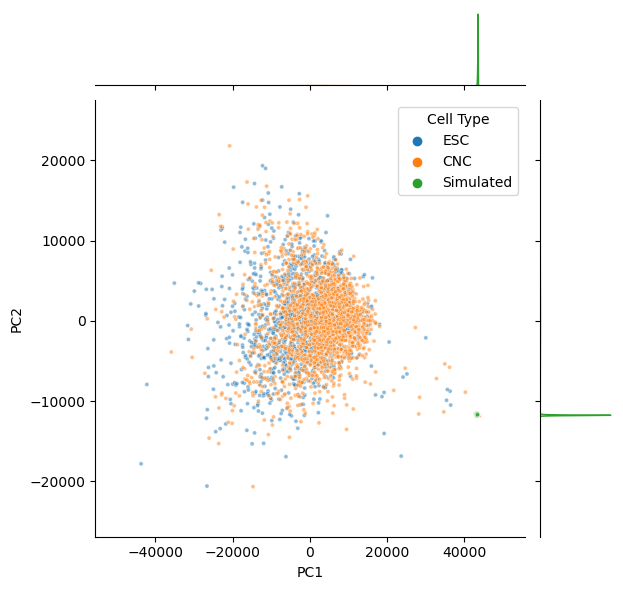

In [75]:
sns.jointplot(data=all_pca_df, x='PC1', y='PC2', hue='Cell Type', kind='scatter', marker='.', alpha=0.5)
plt.savefig(f'{save_dir}/pca_esc_cnc_plot.png', bbox_inches='tight', dpi=300)
# plt.title('Embedding on PCA space defined by ESC and CNC')

In [57]:
# What does it look like if we embed observed data in the PC simulated space
pca_sim = PCA(n_components=2)
pca_sim.fit(dmaps_best_params_flat)
dmaps_sim_pca = pca_sim.transform(dmaps_best_params_flat)
esc_sim_pca = pca_sim.transform(esc_maps_interp_flat)
cnc_sim_pca = pca_sim.transform(cnc_maps_interp_flat)
dmaps_sim_pca_df = pd.DataFrame(dmaps_sim_pca, columns=['PC1', 'PC2'])
dmaps_sim_pca_df['Cell Type'] = 'Simulated'
esc_sim_pca_df = pd.DataFrame(esc_sim_pca, columns=['PC1', 'PC2'])
esc_sim_pca_df['Cell Type'] = 'ESC'
cnc_sim_pca_df = pd.DataFrame(cnc_sim_pca, columns=['PC1', 'PC2'])
cnc_sim_pca_df['Cell Type'] = 'CNC'
all_sim_pca_df = pd.concat([dmaps_sim_pca_df, esc_sim_pca_df, cnc_sim_pca_df])

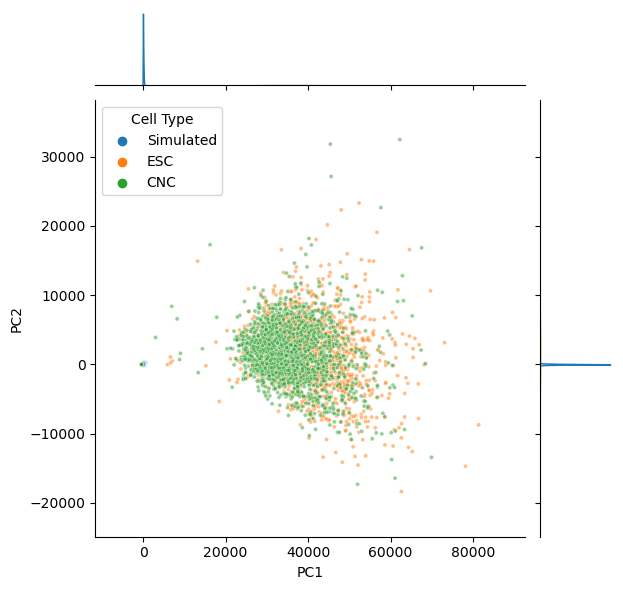

In [76]:
sns.jointplot(data=all_sim_pca_df, x='PC1', y='PC2', hue='Cell Type',  marker='.', alpha=0.5)
plt.savefig(f'{save_dir}/pca_sim_plot.png', bbox_inches='tight', dpi=300)

In [60]:
# Define embedding jointly for observed and simulated data
all_maps_flat = np.concatenate((all_maps_interp_flat, dmaps_best_params_flat), axis=0)
all_pca = PCA(n_components=2)
all_pca.fit(all_maps_flat)
esc_all_pca = all_pca.transform(esc_maps_interp_flat)
cnc_all_pca = all_pca.transform(cnc_maps_interp_flat)
dmaps_all_pca = all_pca.transform(dmaps_best_params_flat)
esc_all_pca_df = pd.DataFrame(esc_all_pca, columns=['PC1', 'PC2'])
esc_all_pca_df['Cell Type'] = 'ESC'
cnc_all_pca_df = pd.DataFrame(cnc_all_pca, columns=['PC1', 'PC2'])
cnc_all_pca_df['Cell Type'] = 'CNC'
sim_all_pca_df = pd.DataFrame(dmaps_all_pca, columns=['PC1', 'PC2'])
sim_all_pca_df['Cell Type'] = 'Simulated'
all_all_pca_df = pd.concat([esc_all_pca_df, cnc_all_pca_df, sim_all_pca_df])

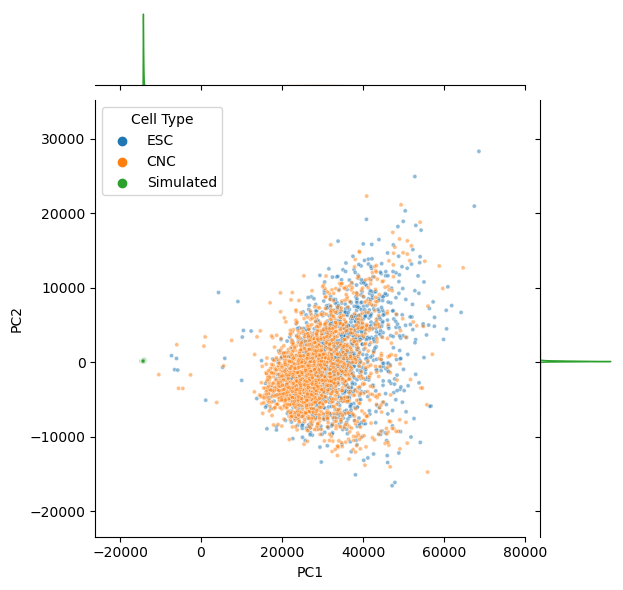

In [77]:
sns.jointplot(data=all_all_pca_df, x='PC1', y='PC2', hue='Cell Type', kind='scatter', marker='.', alpha=0.5)
plt.savefig(f'{save_dir}/pca_all_plot.png', bbox_inches='tight', dpi=300)